<a href="https://colab.research.google.com/github/shreytelang/Calculator-GUI-in-Python/blob/main/M505_Intro_to_AI_%26_ML_%E2%80%94_Individual_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M505 Intro to AI & ML — Individual Final Project

**Title:** Predicting Song Popularity from Audio Features  

**Author:** Shrey Telang

**Student Number:** GH1048666

**Module:** M505 Intro to AI & Machine Learning  

**University:** Gisma University of Applied Sciences

---

## 0. Executive Summary (read me first)
We will be working on end-to-end ML pipeline. Which will help to predict whether a song will be **popular** or not (**target=1**) using audio features (e.g., danceability, energy, valence).  
The pipeline includes: **problem definition → EDA → preprocessing & feature engineering → model selection & tuning → evaluation → business recommendations**.

**Best model (preview):** Determined below via cross validation and hold out testing.  
**Business value:** Identify earlier to prioritize marketing, playlist placements, and A/B testing of production choices.



## 1. Problem Statement

**Business context.** Music labels and platforms have to make decisions on what they shou;d drive in editoral playlists and advertisements. An early audio preduction model can be:
- Targeting **marketing** budgets on high-potential tracks,  
- Enhance the **curation of playlist**, and  
- Give constructive **feedback** to producers and A&R.

**ML task.** Binary **organization** of **target** (1 = popular, 0 = not).

**Success criteria.** Prioritize **recall and ROC-AUC** (early detection of potential hits) while keeping **precision** reasonable to avoid over-spending on false positives.

**Assumptions.**
- **target** should be ground-truth popularity label.  
- Audio features are obtained uniformly.  
- High cardinality and leakage are not prevented by using fields (**song_title, artist**)


# 2. Imports & Data Loading

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Load dataset (expects the uploaded path)
df = pd.read_csv('/content/data.csv')

# Drop index-like column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print('Shape:', df.shape)
print('Columns:', list(df.columns))
df.head()

Shape: (2017, 16)
Columns: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'target', 'song_title', 'artist']


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


## 3. Exploratory Data Analysis (EDA)

-We examine class balance, raw stats, and correlation to guide preprocessing and model choice.

-We eschew seaborn for minimum dependencies.

Class Balance:
 target
0     997
1    1020
Name: count, dtype: int64 

Positive class ratio: 0.506


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000



Correlation with target (top 10):
 target              1.000000
danceability        0.176706
speechiness         0.154006
instrumentalness    0.152594
duration_ms         0.146749
valence             0.107930
time_signature      0.040182
energy              0.039688
tempo               0.034732
key                 0.033594
Name: target, dtype: float64


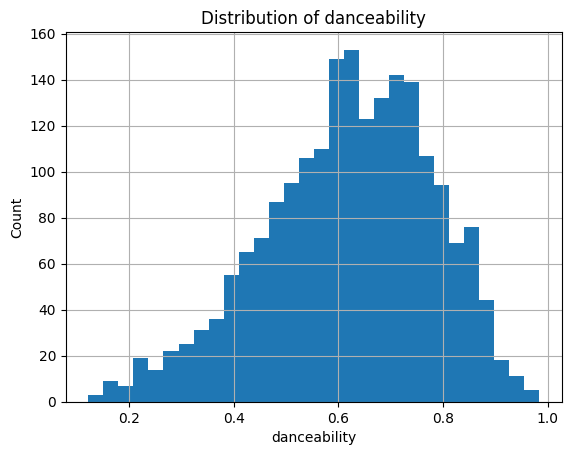

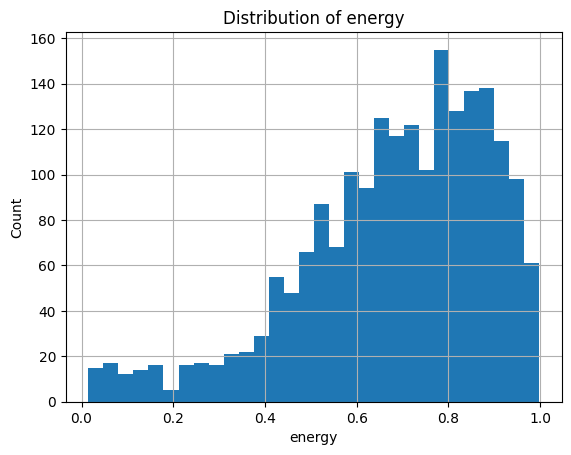

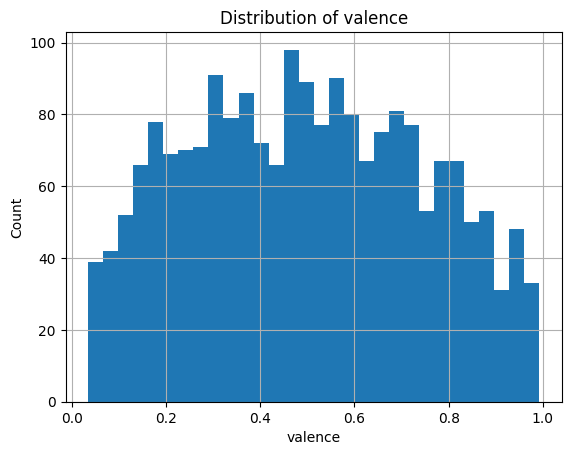

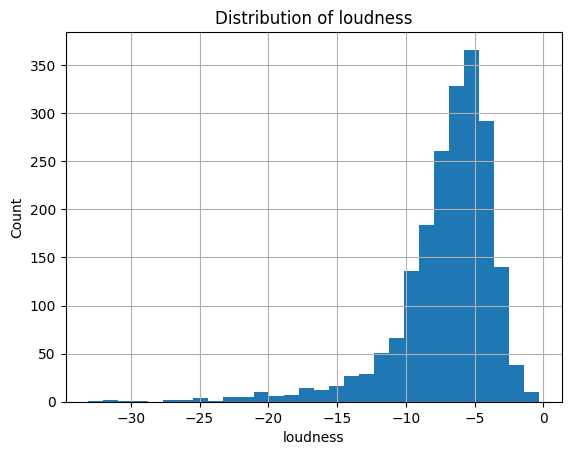

In [ ]:
# Class balance
class_counts = df['target'].value_counts().sort_index()
print('Class Balance:\n', class_counts, '\n')
print('Positive class ratio:', round(class_counts.get(1,0)/class_counts.sum(), 3))

# Basic stats for numeric features
numeric_cols = [c for c in df.columns if df[c].dtype != 'object' and c != 'target']
desc = df[numeric_cols].describe()
display(desc)

# Correlation with target (Pearson on numeric)
corrs = df[numeric_cols + ['target']].corr(numeric_only=True)['target'].sort_values(ascending=False)
print('\nCorrelation with target (top 10):\n', corrs.head(10))

# Quick histogram for a few key features
for col in ['danceability','energy','valence','loudness']:
    if col in df.columns:
        plt.figure()
        df[col].hist(bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

## 4. Preprocessing & Feature Engineering

**Decisions**:
- Eliminate high-cardinality text features: **song_title, artist**.
- Preserve numeric/categorical code features (**key, mode, time_signature**) as numeric.
- Scale numeric features for linear models; **tree models** are scale-insensitive but scaling within a pipeline is harmless.

We encapsulate preprocessing in a **ColumnTransformer** within a Pipeline to ensure reproducibility.

In [ ]:
# Feature/target split
drop_cols = [c for c in ['song_title','artist'] if c in df.columns]
X = df.drop(columns=drop_cols + ['target'])
y = df['target']

# Identify numeric columns
num_cols = [c for c in X.columns if X[c].dtype != 'object']

# Preprocessor: scale numeric features
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='drop'
)

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((1613, 13), (404, 13))

## 5. Model Training & Selection

We compare three baseline models with low-level hyperparameter tuning:
- **Logistic Regression** (interpretable linear baseline)
- **Random Forest** (strong, non-linear)
- **Gradient Boosting** (strong table-based baseline)

We select the best by cross-validated **ROC-AUC** and then evaluate on the hold-out test set.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipelines = {
    'logreg': Pipeline([('prep', preprocessor),
                        ('clf', LogisticRegression(max_iter=1000))]),
    'rf': Pipeline([('prep', preprocessor),
                    ('clf', RandomForestClassifier(random_state=42))]),
    'gb': Pipeline([('prep', preprocessor),
                    ('clf', GradientBoostingClassifier(random_state=42))])
}

param_grids = {
    'logreg': {'clf__C': [0.1, 1.0, 5.0]},
    'rf': {'clf__n_estimators': [200, 400],
           'clf__max_depth': [None, 8, 12]},
    'gb': {'clf__n_estimators': [150, 300],
           'clf__learning_rate': [0.05, 0.1],
           'clf__max_depth': [2, 3]}
}

results = {}
best_models = {}

for name in pipelines:
    grid = GridSearchCV(
        estimator=pipelines[name],
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    results[name] = {'best_params': grid.best_params_, 'best_cv_auc': grid.best_score_}

results

{'logreg': {'best_params': {'clf__C': 5.0},
  'best_cv_auc': np.float64(0.7018268473372313)},
 'rf': {'best_params': {'clf__max_depth': None, 'clf__n_estimators': 400},
  'best_cv_auc': np.float64(0.8531779551655049)},
 'gb': {'best_params': {'clf__learning_rate': 0.1,
   'clf__max_depth': 3,
   'clf__n_estimators': 300},
  'best_cv_auc': np.float64(0.8415092669186908)}}

## 6. Final Evaluation on Test Set


This verifies generalization and selects the **final model**.

We validate the tuned models on the **unknown test set** with:
- Precision, Recall, F1, Accuracy
- ROC-AUC
- Confusion Matrix & ROC Curve

This validates generalization and selects the final model.

,model,accuracy,precision,recall,f1,roc_auc
1,rf,0.762376,0.787234,0.725490,0.755102,0.844914
2,gb,0.747525,0.752475,0.745098,0.748768,0.814326
0,logreg,0.683168,0.690000,0.676471,0.683168,0.728468


<Figure size 640x480 with 0 Axes>

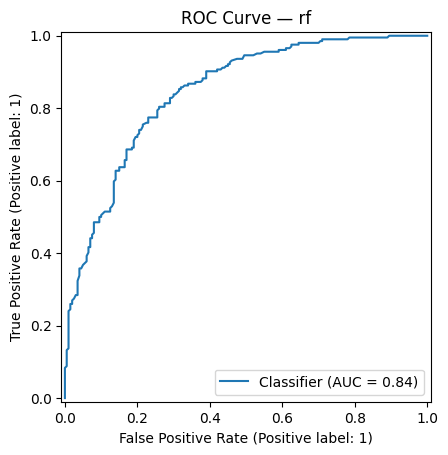

<Figure size 640x480 with 0 Axes>

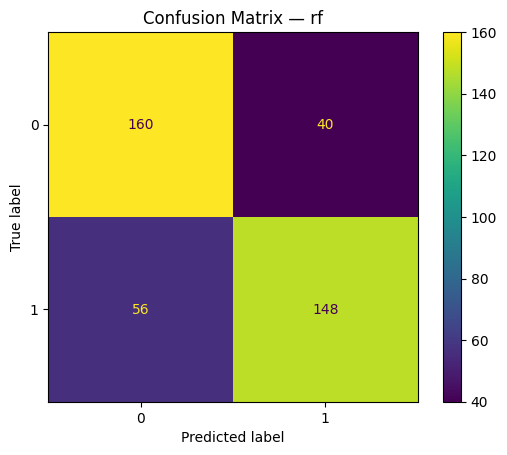

Selected final model: rf


In [ ]:
metrics_table = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    metrics_table.append([name, acc, prec, rec, f1, auc])

metrics_df = pd.DataFrame(metrics_table, columns=['model','accuracy','precision','recall','f1','roc_auc']).sort_values('roc_auc', ascending=False)
display(metrics_df)

# Plot ROC curve for the top model
best_name = metrics_df.iloc[0]['model']
final_model = best_models[best_name]
y_proba_best = final_model.predict_proba(X_test)[:,1]

plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba_best)
plt.title(f'ROC Curve — {best_name}')
plt.show()

# Confusion matrix
plt.figure()
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.title(f'Confusion Matrix — {best_name}')
plt.show()

print('Selected final model:', best_name)

## 7. Feature Importance & Explainability


We offer **feature importances** for tree-based and scaled coefficients for Logistic Regression to pinpoint popularity drivers.

This helps to transmit **actionable levers** (e.g., energy, loudness, valence) to business/creatives.

,feature,importance
7,loudness,0.131087
4,instrumentalness,0.127620
9,speechiness,0.104985
1,danceability,0.096437
3,energy,0.095380
2,duration_ms,0.093224
0,acousticness,0.084551
12,valence,0.082125
10,tempo,0.068817
6,liveness,0.065473


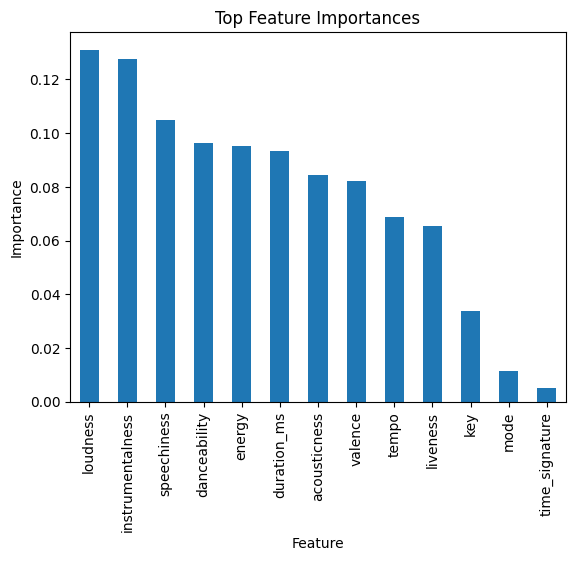

In [ ]:
def get_feature_names(preprocessor, input_cols):
    # Works for simple ColumnTransformer with 'num' only
    num_features = input_cols
    return num_features

feature_names = get_feature_names(preprocessor, num_cols)

best_name = metrics_df.iloc[0]['model']
final_model = best_models[best_name]

if best_name in ['rf','gb']:
    # Tree-based feature importance
    importances = final_model.named_steps['clf'].feature_importances_
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
    display(imp_df.head(15))

    plt.figure()
    imp_df.head(15).set_index('feature')['importance'].plot(kind='bar')
    plt.title('Top Feature Importances')
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()
else:
    # Logistic Regression coefficients
    coefs = final_model.named_steps['clf'].coef_.ravel()
    coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs}).sort_values('coef', ascending=False)
    display(coef_df.head(15))

    plt.figure()
    coef_df.head(15).set_index('feature')['coef'].plot(kind='bar')
    plt.title('Top Positive Coefficients (Scaled)')
    plt.ylabel('Coefficient')
    plt.xlabel('Feature')
    plt.show()

## 8. Discussion & Recommendations


**Strengths.**
- Scalable pipeline with tuning + CV + scaling.
- Top-performing tree model(s) + interpretable linear baseline.
- Metrics and ROC analysis provide clear-cut marketing thresholds.

**Limitations.**
- **target** definition conceals biases; no checks for temporal leakage.
- No raw text/audio feature learning; restricted to tabular proxies only.
- Class imbalance danger lurking in other datasets/settings.

**Business Recommendations.**
1) Utilize the model to **flag high-potential tracks** for early editorial experimentation.
2) Combine predictions with **A/B marketing tests** for optimal spend.
3) Monitor **precision/recall** over time and retrain on new releases.
4) Offer key drivers (e.g., energy, loudness, valence) to producers for **data-driven creative direction**.

**Deployment (next steps).**
- Package the pipeline as a serialized artifact (e.g., **joblib**) behind an API.
- Monitor data drift and execute regular re-training.
- Include model explainability dashboards for the A&R team.

## 9. References (Harvard style examples)
- Pedregosa, F. et al. (2011) ‘Scikit-learn: Machine Learning in Python’, *Journal of Machine Learning Research*, 12, pp. 2825–2830.  
- Raschka, S. (2018) *Python Machine Learning*. 2nd edn. Packt Publishing.
